In [446]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point
import json 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import urllib.request
import cv2
import numpy as np
from slugify import slugify
from pathlib import Path
import shutil


%matplotlib inline

def uninvert_point(p):
    x,y = p

    y = -y + 2000
    return (x,y)

def uninvert_poly(poly):

    return Polygon( uninvert_point(p) for p in poly_to_array(poly))

def norm(pri):
    pri = pri.copy()
    pri[:, 0] = pri[:, 0] - pri[:, 0].mean()
    pri[:, 0] = pri[:, 0] / pri[:, 0].max()
    pri[:, 1] = pri[:, 1] - pri[:, 1].mean()
    pri[:, 1] = pri[:, 1] / pri[:, 1].max()
    return pri

def poly_to_array(poly):

    try:
        return  np.array(poly.exterior.coords)[:-1]
    except AttributeError:
        return poly

def reorder_points(v):
    """Reorder points to ensure the shape is valid. The only works if all of the points
    are on the convex hull, which is true for our shapes. """

    from math import sqrt

    try:
        points = poly_to_array(v).tolist()
    except AttributeError:
        points = v # Hopefully already a list.

    points = poly_to_array(Polygon(v).convex_hull).tolist()

    # Find the point closest to the origin
    # Norming ensures origin finding is consistent. I guess.
    normed_points = norm(np.array(points)) + 10  # +10 to void div by zero in distance

    mp = next(iter(sorted(normed_points, key=lambda p: sqrt(p[0] ** 2 + p[1] ** 1))))

    # Rotate the list of points so the mp point is first in the list
    mpos = normed_points.tolist().index(mp.tolist())
    points = points[mpos:] + points[:mpos]

    return np.array(points)


def get_image(url):
    slug = slugify(url)
    url_response = urllib.request.urlopen(url)

    img_file = Path('/tmp/{}'.format('dlimage-'+slug))
    
    if not img_file.exists():
        with urllib.request.urlopen(url) as response, img_file.open('wb') as out_file:
            print("Download", url)
            shutil.copyfileobj(response, out_file)
    
    with img_file.open('rb') as f:
        img_array = np.array(bytearray(f.read()), dtype=np.uint8)
        return cv2.imdecode(img_array, -1)

p='/Users/eric/proj/data-projects/downtown-partnership/annotations/data/'

df = pd.read_csv(p+'gcp_transforms.csv', index_col=False)
df['tf'] = df.matrix.apply(json.loads)
df['source'] = df.source.apply(wkt.loads).apply(uninvert_poly)
df['source_area'] = df.source.apply(lambda v: v.area)

def bound_dims(v):
    (minx, miny, maxx, maxy) = v.bounds
    return round(maxx-minx,-1), round(maxy-miny,-1)

df['source_shape'] = df.source.apply(bound_dims)
df['source_shape_x'] = df.source_shape.apply(lambda v: v[0])
df['source_shape_y'] = df.source_shape.apply(lambda v: v[1])

rgcp = pd.read_csv(p+'raw_gcp.csv', index_col=False)
def agg_inter(g):
    return ','.join(sorted(g.unique()))

t =rgcp.rename(columns={'image':'url'}).groupby('url').agg({'intersection':agg_inter}).reset_index()
df = df.merge(t, on='url')

df['year'] = df.url.apply(lambda v: Path(v).stem[:4])

# Different maps variants, based on the intersections
map_map = {
    'Ketner_A,Ketner_Broadway,State_A,State_Broadway':   'columbia',
    '11th_B,11th_Broadway,Front_B,Front_Broadway':       'core_columbia',
    '1st_Ash,1st_Cedar,9th_Ash,9th_Cedar':               'cortez',
    '16th_E,16th_Imperial,7th_E,7th_Imperial':           'east_village_a',
    '16th_Imperial,16th_Market,7th_Imperial,7th_Market': 'east_village_b',
    '4th_Broadway,4th_K,6th_Broadway,6th_K':             'gaslamp',
    '3rd_G,3rd_K,Ketner_G,Ketner_Market':                'marina'}

df['map_name'] = t.intersection.apply(lambda v: map_map[v] )

df.map_name.unique()

array(['columbia', 'core_columbia', 'cortez', 'east_village_a',
       'east_village_b', 'gaslamp', 'marina'], dtype=object)

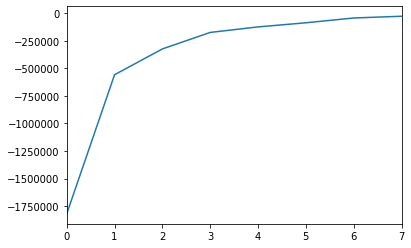

In [469]:
##
## Use KMeans to find clusters of region point shapes, to identify different kinds of maps. 
##
df['map_cluster'] = None

for name, g in df.groupby('map_name'):
    X = g[['source_shape_x','source_shape_y']].values
    
    # If there isn't a lot of variation in the shapes, then skip
    # the clustering. 
    m = X.mean(axis=0) # Centroid
    
    s = [np.linalg.norm(x-m) for x in X]
    
    if pd.Series(s).std() > 100:
    
        #
        # Run the KMeans multiple times and look for the knee in the
        # score vs #clusters plot

        scores = []
        n_clusters = []
        for i in range(2,10):
            kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
            pred = kmeans.predict(X)
            scores.append(kmeans.score(X))
            n_clusters.append(i)

        knee = KneeLocator(x=range(len(scores)), y=scores).knee
        clusters = n_clusters[knee]

        # Now re-run with that number of clusters. 

        kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
        pred = kmeans.predict(X)
    else:
        print('Skipping ', name)
        pred = 0
    
    df.loc[df.map_name==name,'map_cluster'] = pred
   
# dims.plot.scatter(x='x',y='y',c='map_no', colormap='viridis')
pd.Series(scores).plot()

In [506]:

def transform_image(source_poly, target_poly, img):
    """Use the GCP polygon as points to calculate a transform between a target
    images and source image. Results in scaling/translating all images so they overlap. """
    
    img_rows=900*2
    img_cols=1200*2
    
    target_points = np.float32(reorder_points(target_poly))
    img_points = np.float32(reorder_points(source_poly))

    M = cv2.getAffineTransform(img_points[:3],target_points[:3])
    
    #cv2.polylines(img,[img_points.astype(np.int32)],True,(0,0,255), lineType=cv2.LINE_AA, thickness=10)
    
    return M, cv2.warpAffine(img,M,(img_cols,img_rows))

def find_target_poly(neigh_images):
    """Find the image that has GCP points closest to the mean of all images. 
    
    The routine averages together all of the polygons of GCP for a neighborhood, 
    then calculates the cosign similarity between the mean and each polygon to find
    the minimum. Suspicious, but seems to work. 
    
    """
   
    ## 
    polys = [ np.float32(reorder_points(e[1])) for e in neigh_images]
    m = np.mean(polys, axis=0)
    
    # a list of the distances from the mean mean Artithmetric distance is the first, 
    # cosign similiarity is the other. 
    #dists = [ (m- np.float32(reorder_points(e[1]))).mean() for e in n_images]
    dists = [ (1-cosine_similarity(m,np.float32(reorder_points(e[1])))).sum() for e in n_images]
    
    min_index = dists.index(min(dists))
    min_image = polys[min_index]
    
    return min_image
    
from collections import namedtuple
Xform = namedtuple('Xform', 'source_image dest_image M image_poly')

def average_images(target_poly, images):
    """Align all of the neighborhood images, then threshold to monochrome ( Max pixel value of 1).
    Add them all together, so the most common lines in the images -- the block outlines -- have the highest
    resulting value. """
    
    sum_img = None
    
    transforms = {}
  
    
    for image_url, image_poly in images:
    
        img = get_image(image_url)
    
        M, dst = transform_image(image_poly,  target_poly, img )

        gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)

        thresh = cv2.adaptiveThreshold(gray, 1,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

        transforms[image_url] = Xform(img, thresh, M, image_poly)
        
        if sum_img is None:
            sum_img = thresh.copy()
        else:
            sum_img = cv2.add(sum_img,thresh)
            
    return transforms,  sum_img
    
images = [ (idx, [ (r.url, r.source) for idx, r in g.iterrows()])  for idx, g in df.groupby(['map_name', 'map_cluster'])]


archetypes = {}

for neighborhood, n_images in images:

    print(neighborhood, len(n_images))
    
    target_poly = find_target_poly(n_images)
    
    archetypes[neighborhood] = average_images(target_poly, n_images)
    
    

('columbia', 0) 31
('core_columbia', 0) 12
('core_columbia', 1) 10
('core_columbia', 2) 2
('core_columbia', 3) 12
('core_columbia', 4) 8
('core_columbia', 5) 5
('core_columbia', 6) 1
('core_columbia', 7) 1
('core_columbia', 8) 2
('cortez', 0) 9
('cortez', 1) 13
('cortez', 2) 5
('cortez', 3) 4
('cortez', 4) 12
('cortez', 5) 3
('cortez', 6) 4
('cortez', 7) 3
('cortez', 8) 1
('east_village_a', 0) 13
('east_village_a', 1) 9
('east_village_a', 2) 5
('east_village_a', 3) 4
('east_village_a', 4) 4
('east_village_a', 5) 12
('east_village_a', 6) 3
('east_village_a', 7) 1
('east_village_a', 8) 3
('east_village_b', 0) 11
('gaslamp', 0) 4
('gaslamp', 1) 12
('gaslamp', 2) 5
('gaslamp', 3) 2
('gaslamp', 4) 12
('gaslamp', 5) 2
('gaslamp', 6) 1
('gaslamp', 7) 2
('gaslamp', 8) 2
('marina', 0) 13
('marina', 1) 9
('marina', 2) 1
('marina', 3) 8
('marina', 4) 2
('marina', 5) 2
('marina', 6) 4
('marina', 7) 12
('marina', 8) 3


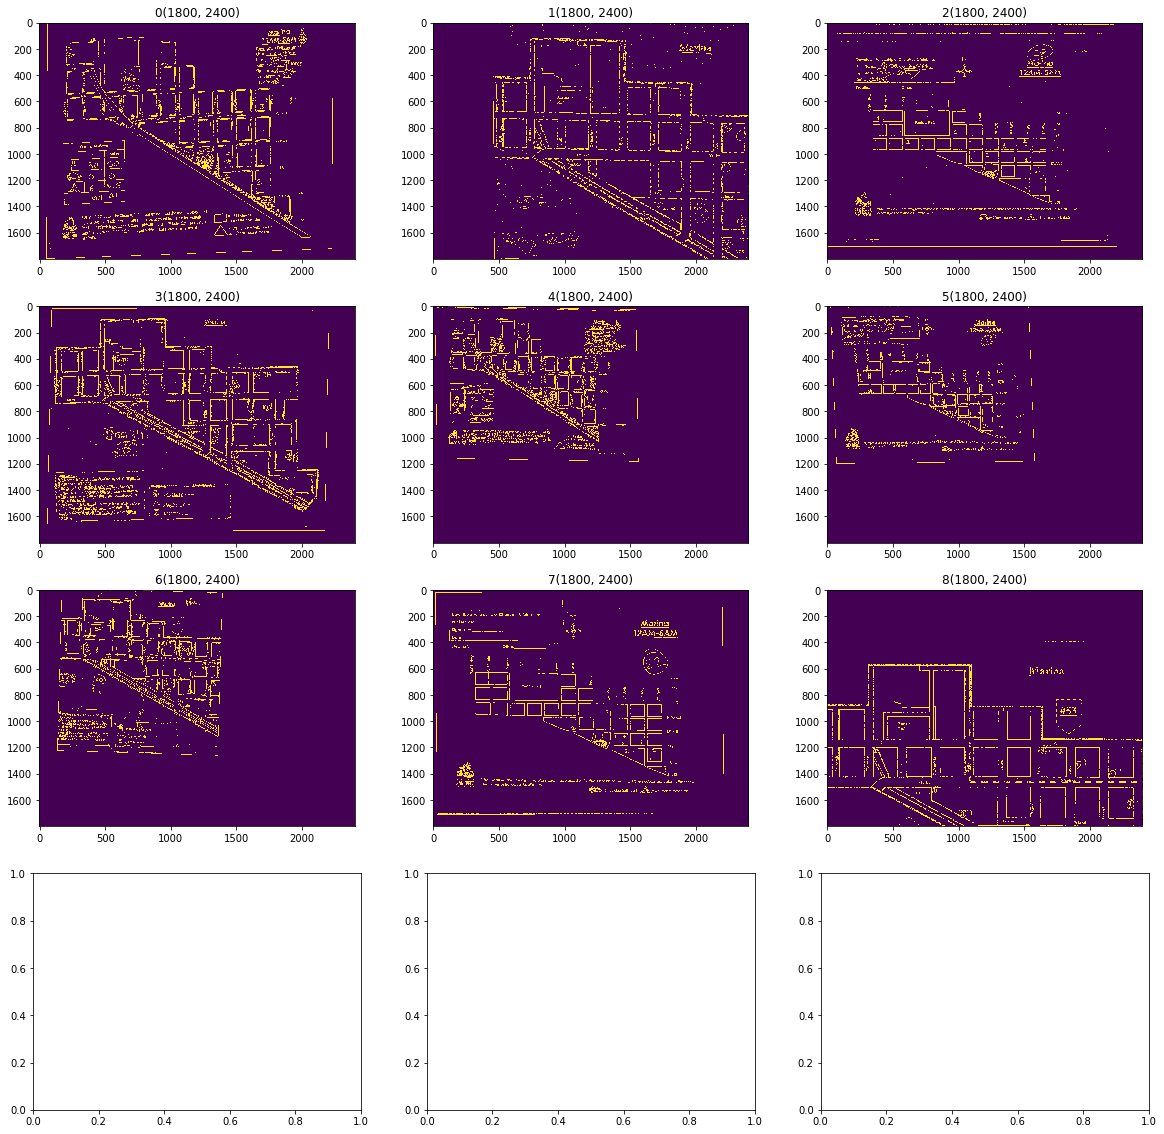

In [505]:
ex_image = {}
for (n,cluster), (xfs, sum_img) in archetypes.items():
  
    if n == 'marina':     
        ex_image[cluster] = list(xfs.values())[0].dest_image
        

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,20))

for ax, (cluster,image) in zip(axes.flat,ex_image.items()):
    ax.imshow(image)
    ax.set_title(str(cluster)+str(image.shape))

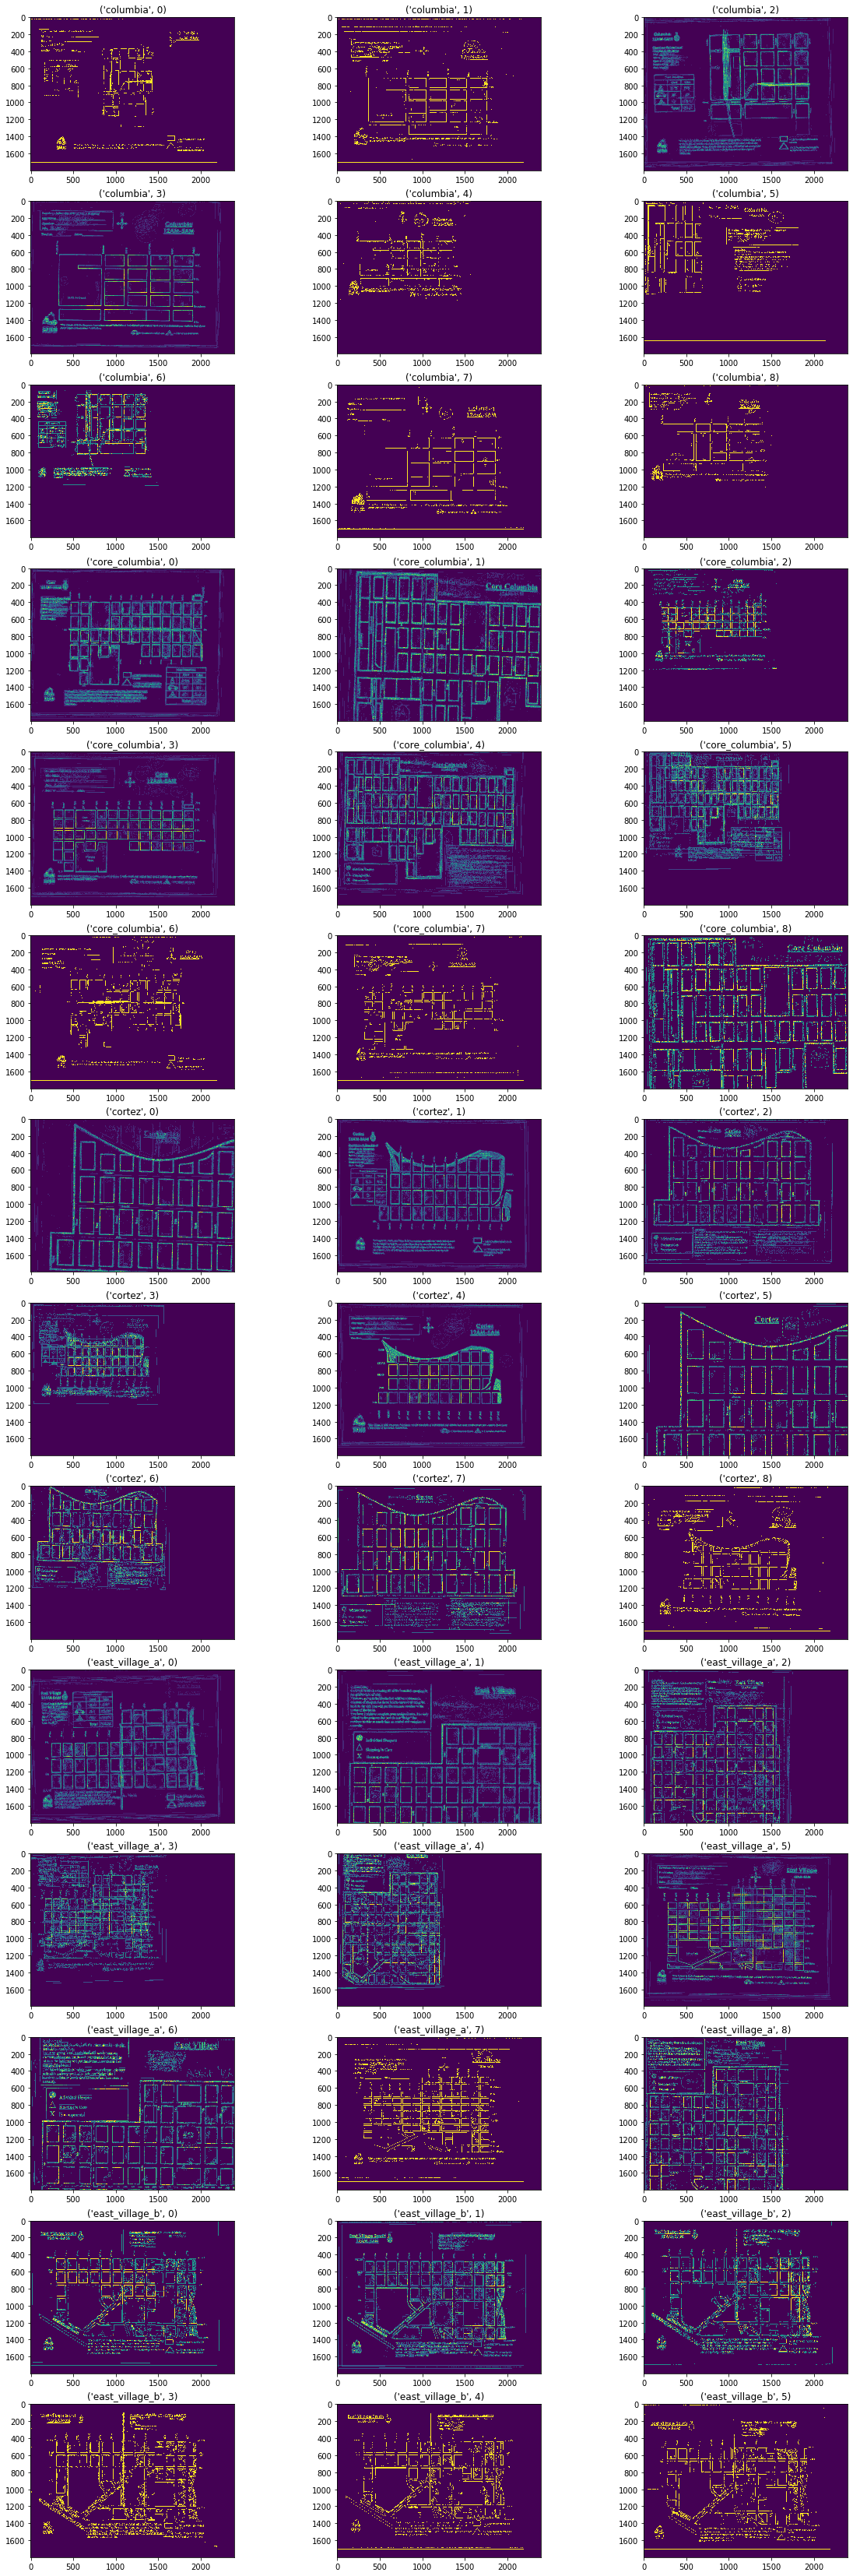

In [445]:
fig, axes = plt.subplots(nrows=14, ncols=3, figsize=(20,60))

for ax, (neighborhood, (transforms, img) )  in zip(list(axes.flat), archetypes.items()):
    ax.imshow(img)
    ax.set_title(neighborhood)


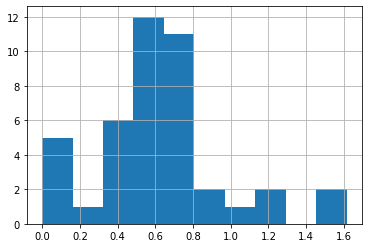

In [307]:
def get_scale(m):
    return m[0][0] * m[1][1]

xfrm, dst_img, img = archetypes['gaslamp']
pd.Series([ get_scale(e) for e in xfrm.values() ]).hist()

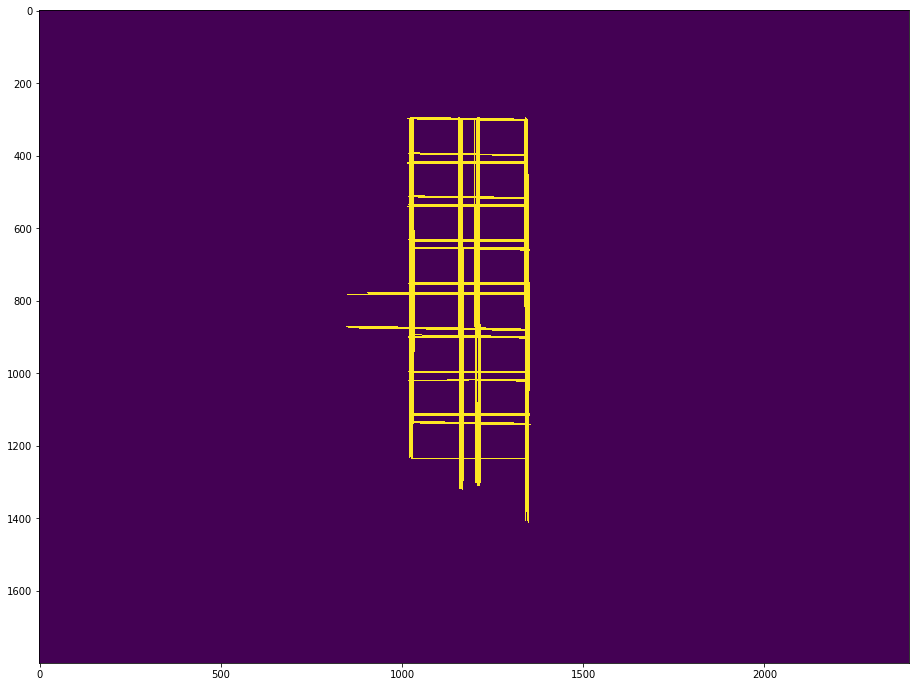

In [240]:
#gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
#gray = cv2.bitwise_not(gray)

#display(pd.Series(img.flatten()).hist())
#display(pd.Series(img.flatten()).value_counts())

def blank_img(img):
    return np.zeros((img.shape),np.uint8)

def thresh(img):

    return cv2.threshold(img, 11, 255,cv2.THRESH_BINARY)[1]

def athresh(img):
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img, 1,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
    #img = cv2.bitwise_not(img)
    img = 1-img
    return img

def lines_lsd(img):
     
    lines = []
        
    lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_ADV, _scale = .7)
    for l in  lsd.detect(img)[0]:
        lines.append(l.flatten())
        
    return np.array(lines)

def lines_hough(img):
     
    lines = []
    
    for l in cv2.HoughLinesP(img,rho = 1,theta = 1*np.pi/180,threshold = 200,minLineLength = 100, maxLineGap = 50):
        lines.append(l[0])
        
    return np.array(lines)
    
def draw_lines(img, lines, min_len=None):
    
    from math import sqrt
    
    def dist(l):
        
        return sqrt ( (l[2]-l[0])**2 +  (l[3]-l[1])**2 )  
    
    # Create a blank image

    for x0, y0, x1, y1 in lines:
   
        if min_len is not None and dist(l) <= min_len:
            continue

        cv2.line(img, (x0, y0), (x1,y1), 255, 2, cv2.LINE_8)

    #img = cv2.bilateralFilter(img,9,75,75)
    
    return img

    
def find_features():
    
    corners = cv2.goodFeaturesToTrack(img, 50, .2, 50)
    for e in corners:
        pass
        #cv2.circle(img, tuple(e[0]), 20, 127, 2 )

img = list(archetypes.values())[5]

plt.figure(figsize=(16,12))
img = thresh(img)

#img = draw_lines(blank_img(img), lines_lsd(img), 15)
#img = cv2.GaussianBlur(img, (0,0), 5)
img = draw_lines(blank_img(img), lines_hough(img))

plt.imshow(img)




In [262]:
cc_images = []
for map_name, n_images in images:
    if map_name == 'east_village_a':
        for image in n_images:
            cc_images.append(get_image(image[0]))

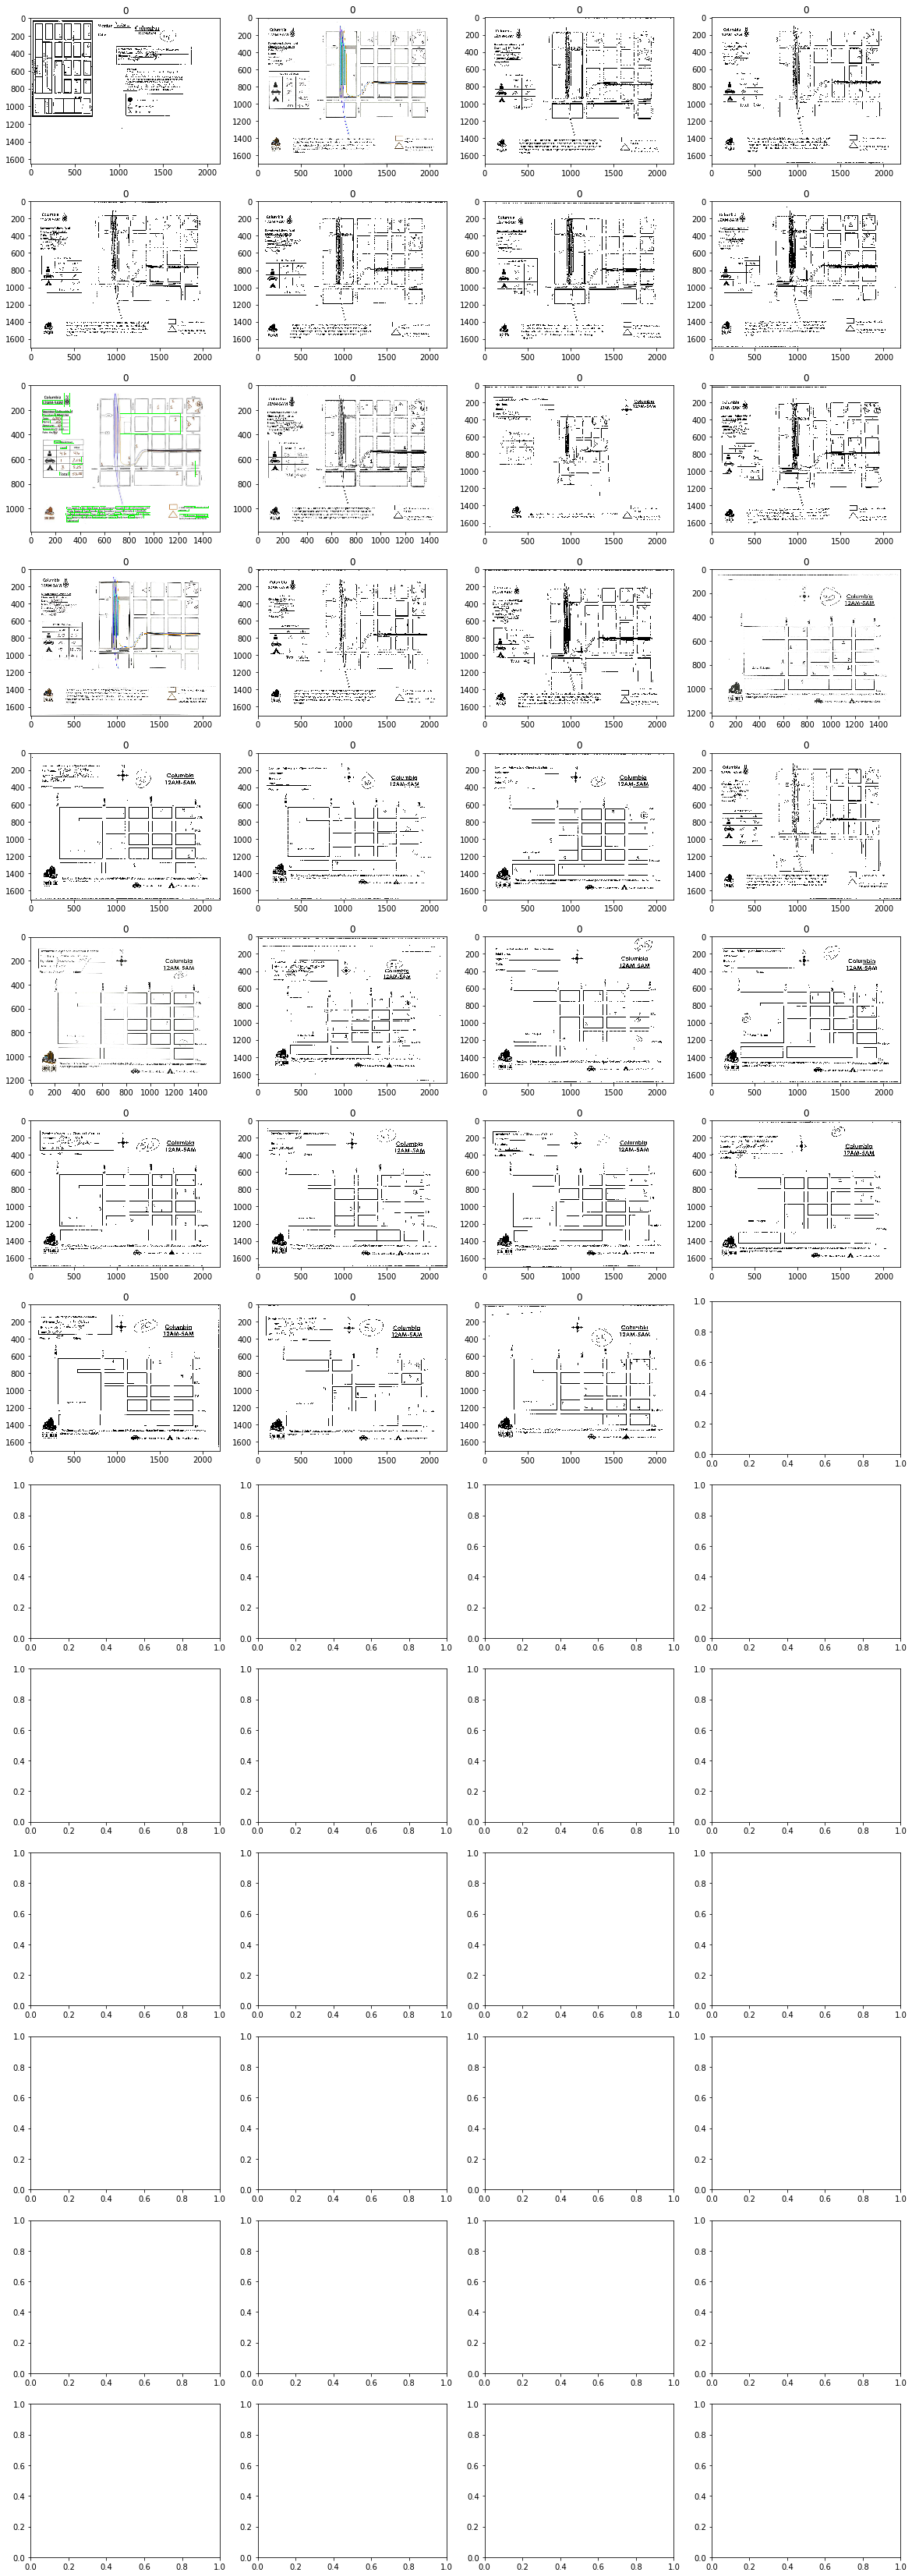

In [470]:
fig, axes = plt.subplots(nrows=14, ncols=4, figsize=(20,60))

#for ax, img in zip(axes.flat, cc_images):
#    ax.imshow(img)

t = df.sort_values('map_cluster')

for (idx, row), ax in zip(t[t.map_name== 'columbia'].iterrows(), axes.flat):
    img = get_image(row.url)
    ax.imshow(img)
    ax.set_title(row.map_cluster)
    


columbia 79809.49756304735
core_columbia 283520.7000346126
cortez 459752.57157545123
east_village_a 972725.3175624505
east_village_b 7212.029424640127
gaslamp 325123.3574134047
marina 406603.349902696


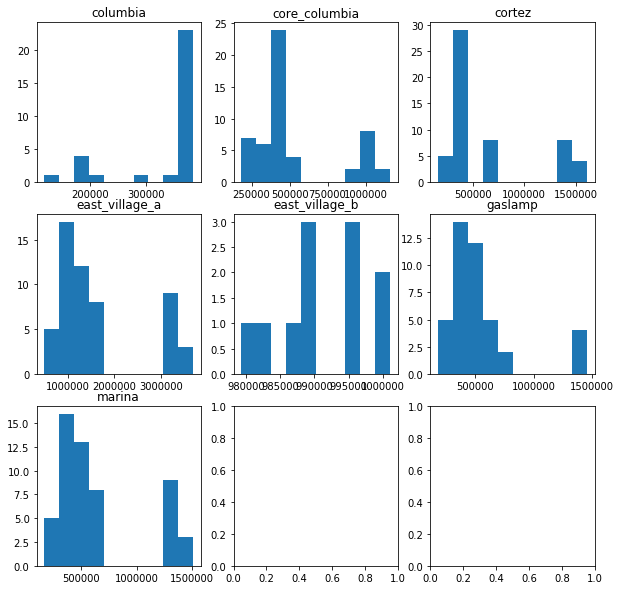

In [376]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))


for (name, g), ax in zip(df.groupby('map_name'), axes.flat):
    ax.hist(g.source_area)
    ax.set_title(name)
    print(name, g.source_area.std())


In [381]:
dims = pd.DataFrame({
    'map_no': df.map_name.astype('category').cat.codes,
    'map_name': df.map_name,
    'x': df.source_shape.apply(lambda v: v[0]),
    'y': df.source_shape.apply(lambda v: v[1])
})

dims.head()


,map_no,map_name,x,y
0,0,columbia,330.0,620.0
1,0,columbia,720.0,410.0
2,0,columbia,590.0,340.0
3,0,columbia,780.0,460.0
4,0,columbia,560.0,330.0


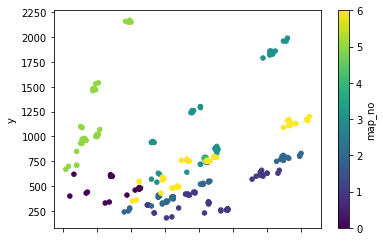

/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/eric/anaconda3/envs/metatab-dev/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return_n_iter=True)


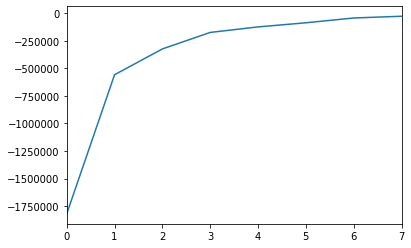

In [440]:
df.head().T

,0,1,2,3,4
url,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....,http://ds.civicknowledge.org/downtownsandiego....
neighborhood,columbia,columbia,columbia,columbia,columbia
source,"POLYGON ((262 257, 262.5 877, 585.5 881.5, 590...","POLYGON ((832.5 839, 827.5 1246.5, 1541.5 1249...","POLYGON ((605 573.5, 602 914, 1188 914, 1185 5...","POLYGON ((844.5 772.5, 848.5 1222.5, 1626.5 12...","POLYGON ((627 577, 626 902.5, 1186.5 904.5, 11..."
dest,"POLYGON ((6278946 1841436.99999983, 6278953.17...","POLYGON ((6278946 1841436.99999983, 6278953.17...","POLYGON ((6278946 1841436.99999983, 6278953.17...","POLYGON ((6278946 1841436.99999983, 6278953.17...","POLYGON ((6278946 1841436.99999983, 6278953.17..."
matrix,"[[2.532279144233197, 0.003906776153235504, 0.0...","[[1.1569821727363658, -0.00034090625478441636,...","[[1.4149828534968452, 0.0026550014295647142, 0...","[[1.0569914364795376, 0.0030690793601490965, 0...","[[1.4718082874478764, 0.00020322881428490105, ..."
tf,"[[2.532279144233197, 0.003906776153235504, 0.0...","[[1.1569821727363658, -0.00034090625478441636,...","[[1.4149828534968452, 0.0026550014295647142, 0...","[[1.0569914364795376, 0.0030690793601490965, 0...","[[1.4718082874478764, 0.00020322881428490105, ..."
source_area,202299,291446,197346,352782,182724
source_shape,"(330.0, 620.0)","(720.0, 410.0)","(590.0, 340.0)","(780.0, 460.0)","(560.0, 330.0)"
source_shape_x,330,720,590,780,560
source_shape_y,620,410,340,460,330


In [387]:

X = df[df.map_name=='gaslamp'].source_shape.values
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
pred = kmeans.predict(X)

ax =plt.scatter(x=X[:,0], y=X[:,1])
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1]);


ValueError: setting an array element with a sequence.

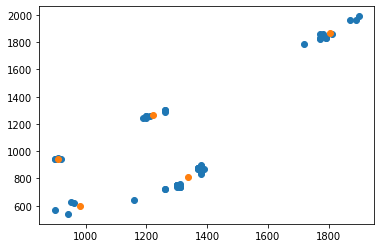

In [372]:
from sklearn.cluster import KMeans
X = dims[dims.map_name=='east_village_a'][['x','y']].values
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
pred = kmeans.predict(X)

ax =plt.scatter(x=X[:,0], y=X[:,1])
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1]);

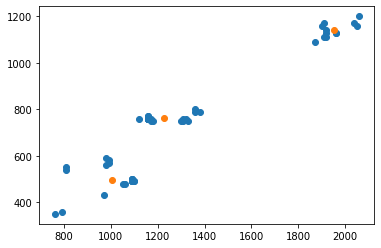

In [451]:
from sklearn.cluster import KMeans
X = dims[dims.map_name=='marina'][['x','y']].values
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
pred = kmeans.predict(X)

ax =plt.scatter(x=X[:,0], y=X[:,1])
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1]);

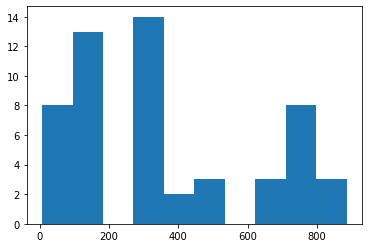